### Build A toric knot structure which are classified as alternating concentric circles with 0,1 targets.

In [1]:
import numpy as np
from scipy import stats

np.random.seed(122)
points = np.random.uniform(low=-10, high=10, size=(80000, 2))
distance_from_origin = np.sqrt(points[:, 0] ** 2 + points[:, 1] ** 2)
condition = np.where((np.floor(distance_from_origin) % 2 == 1) & (distance_from_origin <= 10))
X = points[condition]
y = np.apply_along_axis(lambda x: int((np.floor(np.sqrt(x[0] ** 2 + x[1] ** 2)) % 4 == 1)), 1, X)[np.newaxis].T
X=stats.zscore(X)
full = np.hstack((X, y))

### Objective is to classify points in this 2D plane based on their colors
### All the points in yellow region belong to Target 0 and purple belong to 1.

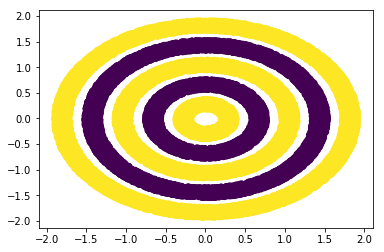

In [4]:
%matplotlib inline
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(full[:,0], full[:,1], c=full[:,2])

### We build a neural network with three hidden layers and sigmoid activation
### Some house keeping and helper funcitons for building a neural netowrk

In [108]:
dim=X.shape[1]
learning_rate=0.3
hidden_layers=[20,20,12]
classes=1
complete_layers=[dim]+hidden_layers+[1]
weight_sizes=zip(complete_layers[:-1],complete_layers[1:])
weights = [np.random.normal(0,1,weight_size) for weight_size in weight_sizes]
biases = [np.random.normal(0,1,bias_size) for bias_size in complete_layers[1:]]

###logistic sigmoid function
def sigmoid(x,weights,bias):
    theta=np.dot(x,weights)+bias
    return 1/(1+np.exp(-theta))

##Computes accuracy of neural network on the entire trianing set
def accuracy_compute(signal,y_t):
    predict=[int(t>0.5) for t in signal]
    incorrects=np.sum(np.abs(np.array(predict)-y_t.T))
    return (len(predict) - incorrects)*100/len(predict)

## Generate random batch indexes for the array .
def generate_batches( array, batch):
    row_indexes = np.arange(array.shape[0])
    while row_indexes.shape[0] > batch:
        sample_indexes = list(np.random.choice(np.arange(len(row_indexes)), batch, replace=False))
        val = np.take(row_indexes,sample_indexes)
        row_indexes=np.delete(row_indexes,sample_indexes)
        yield list(val)
        
##does a forward propogation on the entire training set 
def inference(X_t, y_t,weights,biases):
    for (w,b) in zip(weights,biases):
        X_t = sigmoid(X_t, w, b)
    return accuracy_compute(X_t, y_t)

In [109]:
%%time
##backpropogation : refer to http://ufldl.stanford.edu/wiki/index.php/Backpropagation_Algorithm
def forward_backward_prop(unactivated,y_t,forward_weights,forward_biases):
    if len(weights)==0:
        return (unactivated-y_t)/y_t.shape[0],[],[]
    current_layer_weights,current_layer_bias=forward_weights.pop(0),forward_biases.pop(0)
    activated=sigmoid(unactivated,current_layer_weights,current_layer_bias)
    
    forward_layer_gradients,backward_weights,backward_biases=forward_backward_prop(activated,y_t,forward_weights,forward_biases)
    node_backprop_next_layer=forward_layer_gradients * activated*(1-activated)
    
    ### row wise kronecker product written in einstein summation, 
    ### each forward layers gradients are kronecker multipled with the previous layer 
    ### finally we take a summation over all points in the batch
    weight_updates = np.sum(np.einsum('bi,bo->bio', unactivated,node_backprop_next_layer,optimize=True), axis=0)
    backward_weights.append(current_layer_weights-learning_rate*weight_updates)
    backward_biases.append(current_layer_bias-learning_rate*np.sum(node_backprop_next_layer,axis=0)) 
    
    #Updated previous layers are appended and sent back to the next layers
    #also the gradients of each node are sent back to the next layer
    return np.dot(forward_layer_gradients,current_layer_weights.T),backward_weights,backward_biases


### run epochs untill an accuracy of 95% is achieved
accuracy=-np.inf
i=0
while accuracy<95:
    for batch in generate_batches(X, 100):
        grads,weights,biases=forward_backward_prop(X[batch],y[batch],weights,biases)
        weights=weights[::-1]
        biases=biases[::-1]
    i+=1
    accuracy = inference(X, y,weights,biases)
    if i%20 ==0 : print("-------- epoch : %d , accuracy : %.8f --------- " % (i,accuracy))
print("-------- epoch : %d , accuracy : %.8f --------- " % (i,accuracy))

-------- epoch : 20 , accuracy : 94.68770774 --------- 
-------- epoch : 21 , accuracy : 95.03164831 --------- 
CPU times: user 38.6 s, sys: 1.15 s, total: 39.8 s
Wall time: 10 s
